In [6]:
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.makers import MapDatasetMaker,SafeMaskMaker
from gammapy.irf import EDispKernel
from gammapy.makers.utils import make_psf_map
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels
)
from gammapy.modeling import Fit

1.0


In [7]:
import os
os.chdir('../EventDataset/')
from EventDatasetMaker import EventDatasetMaker
from EventDataset import EventDataset

In [8]:
%load_ext autoreload
%autoreload 2

## Set up a binned and unbinned Dataset

In [9]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

In [6]:
## define the geometry
nebins = 20
binsz = 0.02*u.deg

crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.geomspace(1,100,nebins)
energy_axis = MapAxis.from_edges(
    ebins[:-1], unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=binsz,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [7]:
%%time
maker = MapDatasetMaker(selection=["counts", 'exposure','edisp', 'background', 'psf'])
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg', bias_percent=8)

reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)

bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model

CPU times: user 978 ms, sys: 105 ms, total: 1.08 s
Wall time: 5.43 s


In [7]:
%%time
test_maker = EventDatasetMaker(safe_mask_maker=maker_safe_mask, selection=None)
eds = test_maker.run(reference, obs1)

bkg_model2 = FoVBackgroundModel(dataset_name=eds.name)
eds.models=bkg_model2

CPU times: user 800 ms, sys: 35 ms, total: 835 ms
Wall time: 1.01 s


In [29]:
model_gauss = SkyModel(
    spatial_model=PointSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model'
    )
crab_ampl = model_gauss.spectral_model.amplitude.value
model_gauss.spatial_model.parameters.freeze_all()
dataset.models = [bkg_model,model_gauss]
eds.models = [bkg_model2,model_gauss.copy(name="crab_model")]

# to make it fair set the same binsz
eds.evaluators['crab_model'].spatialbs = binsz

In [9]:
## need to monkey patch the paramter_norm_only_changed methods 
## because otherwise a simple rescaling would happen
@property
def pnoc_patch(self):
    """Only norm parameter changed"""
    norm_only_changed = False
    return norm_only_changed


# disable caching
ev_ds=dataset.evaluators['crab_model']
ev_eds=eds.evaluators['crab_model']
ev_ds.use_cache = False
ev_eds.use_cache = False
# at the moment parameter_norm_only_changed return False always
# if that is fixed we would need to monkey patch it
# this is hard because it is @property decorated so better patch _compute_npred()

In [10]:
%prun -s cumtime eds.stat_sum()

In [11]:
ev_eds.geom

WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (10, 10, 19)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 0.2 deg x 0.2 deg
	wcs ref    : 83.6 deg, 21.5 deg

## Timing

In [12]:
sampler = MapDatasetEventSampler(random_state=0)

In [13]:
obs_time = obs1.observation_time_duration
exposure_obs = dataset.exposure.copy()
obs_time

<Quantity 1687. s>

In [31]:
%%time
result_fluxscale = {}
for scale in [0.1,1]:
    model_gauss.spectral_model.amplitude.value = crab_ampl*scale
    times_bin = Table(names = ['n_events','n_sig','n_bkg','mean', 'std', 'sim_time'])
    times_unb = Table(names = ['n_events','mean', 'std', 'sim_time'])
    for sim_time in [0.5,1,2,4,8,16]*u.h:
    # sim_time = 2*u.h
        rescale = (sim_time / obs_time).to_value('')
        dataset.exposure.data = exposure_obs.data * rescale
        dataset.background_model.parameters['norm'].value = rescale
        dataset.evaluators['crab_model'].update(dataset.exposure, 
                                                dataset.psf, 
                                                dataset.edisp, 
                                                dataset._geom, 
                                                dataset.mask_image)

        events = sampler.run(dataset, obs1)
        dataset.counts.data *= 0
        dataset.counts.fill_events(events)
        eds.events = events
        eds.evaluators['crab_model'].exposure = None # force update
        eds._response_bkg_cached = None

        # calculate the stat_sum once for both
        print(eds.stat_sum())
        print(dataset.stat_sum())

        n_events_unb = len(eds.events_in_mask.table)
        n_events_bin = np.sum(dataset.counts.data[dataset.mask])
        if n_events_unb != n_events_bin:
            print(sim_time,n_events_unb,n_events_bin)

        time_bin = %timeit -n10 -r3 -o dataset.stat_sum()
        time_unb = %timeit -n10 -r3 -o eds.stat_sum()

        n_sig = np.count_nonzero(events.table["MC_ID"])
        n_bkg = np.count_nonzero(events.table["MC_ID"]==0)

        result_bin = {'n_events':n_events_bin,
                      'n_sig':n_sig,
                      'n_bkg':n_bkg,
                      'mean':time_bin.average, 
                      'std':time_bin.stdev,
                      'sim_time': sim_time}
        result_unb = {'n_events':n_events_unb, 
                      'mean':time_unb.average, 
                      'std':time_unb.stdev,
                      'sim_time': sim_time}
        times_bin.add_row(result_bin)
        times_unb.add_row(result_unb)
        
    result_fluxscale[scale] = times_bin, times_unb

-29585.861503585384
15701.165355701321
7.95 ms ± 48.8 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
1.74 ms ± 26.2 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-56512.54559141473
25765.297184019742
7.98 ms ± 64 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
2.16 ms ± 39.6 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-120977.85741466044
45824.88972185306
7.96 ms ± 66 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
3.11 ms ± 50.3 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-239510.96042926714
76487.97636706999
7.97 ms ± 42.7 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
4.97 ms ± 51.6 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-475497.1036639713
123385.96460928627
8.01 ms ± 48.5 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
8.61 ms ± 67.7 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-958003.5255296624
191020.4080690849
8.17 ms ± 98 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
16.2 ms ± 148 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-30482.545322988793
15462.523984140023
7.92 ms ± 34 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
1.77 ms ± 26.6 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-64735.396523195624
27609.413002417554
7.99 ms ± 34.6 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
2.23 ms ± 27.5 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-131423.54862653487
47253.46844466605
7.96 ms ± 59.4 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
3.21 ms ± 69.9 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-270092.7948876931
79226.70959289717
8.02 ms ± 47.5 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
5.26 ms ± 41.4 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-541430.4871397488
126003.25850949
8.13 ms ± 71.2 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
9 ms ± 74 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


-1072125.3287392184
187419.86285245212
8.11 ms ± 77.1 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
16.8 ms ± 114 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
CPU times: user 47.5 s, sys: 6.77 s, total: 54.3 s
Wall time: 55.1 s


Text(0.5, 0, 'Number of events')

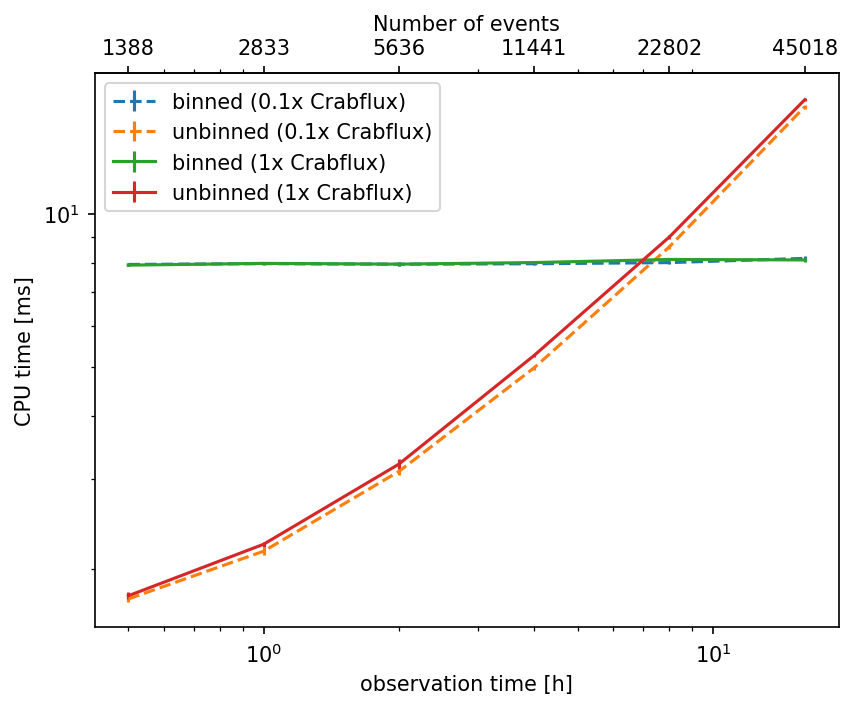

In [33]:
fig, ax = plt.subplots(dpi=150)
time_fac = 1e3 # ms
linestyles = {0.1:"--", 1:"-"}
for k,v in result_fluxscale.items():
    times_bin, times_unb = v
    ls = linestyles[k]
    ax.errorbar(times_bin['sim_time'], 
                times_bin['mean']*time_fac, yerr=times_bin['std']*time_fac, 
                label=f'binned ({k}x Crabflux)', ls=ls)
    ax.errorbar(times_unb['sim_time'], 
                times_unb['mean']*time_fac, yerr=times_unb['std']*time_fac, 
                label=f'unbinned ({k}x Crabflux)', ls=ls)
ax.legend()
ax.set_xlabel('observation time [h]')
ax.set_ylabel('CPU time [ms]')
ax.loglog()

ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(times_unb['sim_time'], labels=times_unb['n_events'].astype(int))
ax2.set_xlabel('Number of events')

In [21]:
np.count_nonzero(events.table["MC_ID"])

7204

In [22]:
np.count_nonzero(events.table["MC_ID"]==0)

63565

In [32]:
result_fluxscale

{0.1: (<Table length=6>
  n_events  n_sig   n_bkg          mean                  std           sim_time
  float64  float64 float64       float64               float64         float64 
  -------- ------- ------- -------------------- ---------------------- --------
    1372.0    19.0  2058.0 0.007947139845540126 4.8768678567849545e-05      0.5
    2519.0    32.0  3921.0 0.007976584819455942  6.403739890207509e-05      1.0
    5250.0    57.0  7968.0 0.007955801300704479  6.598979524098395e-05      2.0
   10314.0   112.0 15985.0 0.007972587179392575  4.274790354315627e-05      4.0
   20366.0   233.0 31409.0 0.008014111562321583 4.8549245382468236e-05      8.0
   40927.0   454.0 62946.0 0.008168889038885633  9.795075481214072e-05     16.0,
  <Table length=6>
  n_events          mean                  std           sim_time
  float64         float64               float64         float64 
  -------- --------------------- ---------------------- --------
    1372.0   0.00174309437473615 2.622325